# Load

In [396]:
%matplotlib inline
# ^^^ Important for movies to work!

In [391]:
import numpy as np
import scipy as sp
from scipy import integrate, linalg, signal
from time import sleep

from IPython.display import HTML, display, Markdown
import matplotlib.pyplot as plt

In [392]:
import importlib
ch = importlib.import_module('control_helper')

In [393]:
ch = importlib.reload(ch)

# Dynamics

Note to the reader:
The point of this notebook is to work out results somewhat explicitely, but many of these features can be accomplished by scipy.signal.StateSpace, also.

Also, there are other movie options available in the helper python file but the ones shown here are best for version control purposes.

(in the repo, there is an accompanying mathematica notebook to work out these results)

Solve the Hamilton equations of motion for the state variable X of the cartpole system to find the 1st order equation of motion $\dot{X} = f(X,t)$:

\begin{align}
    \dot{x}        &= \frac{- ml \cos(\theta) p_\theta + ml^2 p_x }{d(\theta)} \\
    \dot{p_x}      &= 0 \\
    \dot{\theta}   &= \frac{ (M+m) p_\theta - ml \cos(\theta) p_x }{d(\theta)} \\
    \dot{p_\theta} &= - \frac{l^2 m p_x^2 d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \cos (\theta ) d'(\theta )}{d(\theta )^2}+\frac{p_\theta^2 (m+M) d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \sin (\theta )}{d(\theta )}+g l m \sin (\theta )
\end{align}

with 
$d(\theta) = ml^2 (M + m \sin^2(\theta) )$

Use ode45 to time-evolve the dynamical system, and make a movie of the result.

Comments:
- Gravity can be adjusted as an optional parameter to tool with the units.
- (An advantage of Hamilton's formalism) Friction will affect the px equation of motion only.

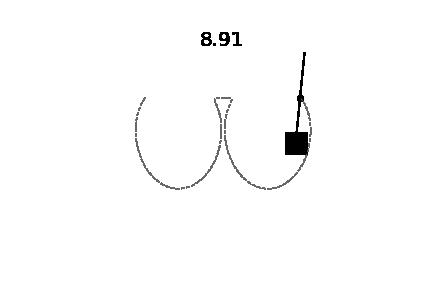

In [5]:
# c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2, 'length_pole': .75, 'gravity': 1})
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1})
y0 = [0, 1, 0, 0]
tmin, tmax = [0,9]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
ch.make_movie_with_buffer(c, x, th, time)

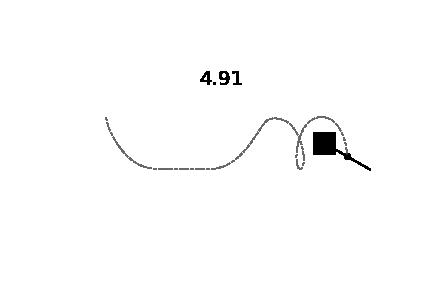

In [7]:
c = ch.cartpole({'mass_cart': 1.492, 'mass_pole': 3, 'length_pole': .75, 'gravity': 2, 'friction': 1})

y0 = [0, 5, 0, 0]
tmin, tmax = [0,5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
ch.make_movie_with_buffer(c, x, th, time)

# Controllability

Find the fixed points of the dynamics. Then, compute the Jacobian and evaluate the result at the fixed points of 
$p_x \rightarrow 0, p_\theta \rightarrow 0, \theta \rightarrow 0, \pi$:

\[
    J = \left(
    \begin{array}{cccc}
     0 & \frac{1}{M} & 0 & -\frac{1}{l M} \\
     0 & -\frac{\eta }{M} & 0 & \frac{\eta }{l M} \\
     0 & -\frac{1}{l M} & 0 & \frac{m+M}{l^2 m M} \\
     0 & 0 & g l m & 0 \\
    \end{array}
    \right)
\]

The variable $s$ holds the sign associated with $\pi \Rightarrow s = -1$ and $0 \Rightarrow s = 1$. The $\eta$ refers to friction.

## Stable fixed point

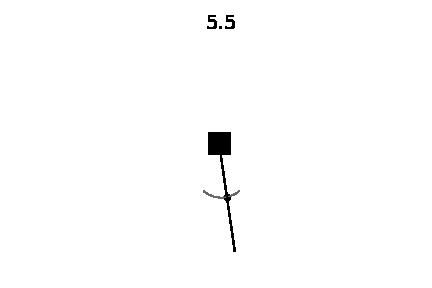

In [187]:
# Control system
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1, 'friction': 0})
tmin, tmax = [0,5.5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.1))

ys = np.array([0, 0,np.pi,0])
y0 = np.array([0, 0,np.pi+0.5,0])

linear_res = np.array([sp.linalg.expm(c.A(-1) * t)@(y0-ys)+ys for t in time])
x,px,th,pth = linear_res.T
                   
ch.make_movie_with_buffer(c, x, th, time, tdiv=1)

## Unstable fixed point

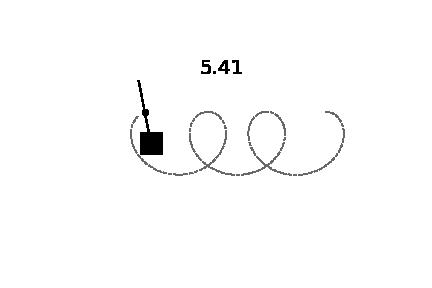

In [7]:
yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0,0.001,0]) # displacement

tmin, tmax = [0, 5.5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
                   
# Notice how it spirals away. We want to control this.
linear_res = np.array([sp.linalg.expm(c.A(1) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
ch.make_movie_with_buffer(c, x, th, time)

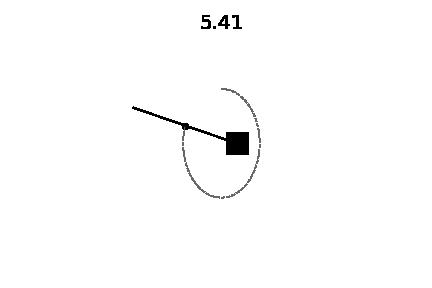

In [8]:
# Notice the correct dynamics for our unstable fixed point do not spiral away.      
# (Run the previous cell immediately before this one.)
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)
x,px,th,pth = res.y
ch.make_movie_with_buffer(c, x, th, time)

## Placing control poles

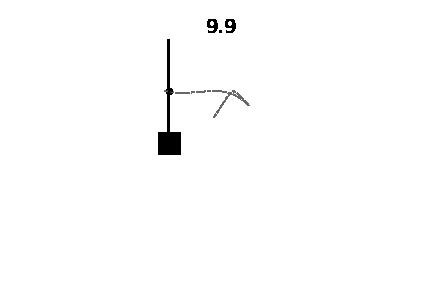

In [10]:
# Control aggressively
A = c.A(1)
B = c.B(2)
fsf = signal.place_poles(A, B, [-1-1j,-1+1j,-2-2j,-2+2j])
K = fsf.gain_matrix

yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0, np.pi/3, 0]) # displacement

tmin, tmax = [0, 10]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.1))
                   
linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T

ch.make_movie_with_buffer(c, x, th, time, tdiv=2)

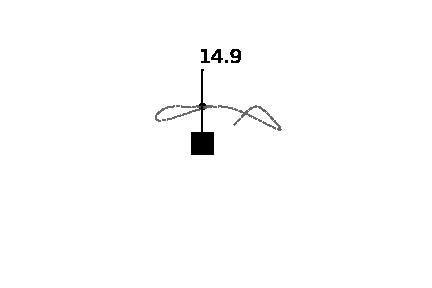

In [11]:
# Control weakly
A = c.A(1)
B = c.B(2)

fsf = signal.place_poles(A, B, [-.3-1j,-.3+1j,-.5-2j,-.5+2j])
K = fsf.gain_matrix

yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0, np.pi/3, 0]) # displacement

tmin, tmax = [0, 15]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.1))
                   
linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
ch.make_movie_with_buffer(c, x, th, time, tdiv=2)

## Linear Quadratic Regulator
Solve the algebraic ricatti equation to get a solution for the optimal control operator

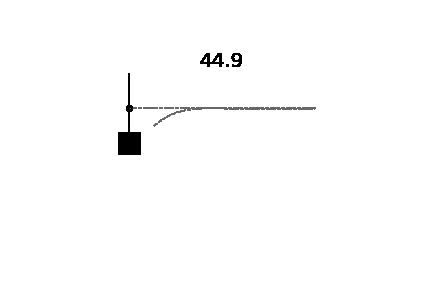

In [12]:
A = c.A(1)
B = c.B(1)

Q = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,10,0],
    [0,0,0,100]
])

R = np.array([[10]])
K,_,_ = ch.lqr(A,B,Q,R)

yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0, np.pi/3, 0]) # displacement

tmin, tmax = [0, 45]
time = np.linspace(tmin,tmax,int((tmax-tmin)/0.1))

linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
ch.make_movie_with_buffer(c, x, th, time, tdiv=2)

In [2]:
# Check for controllability by looking at the rank of the controllability matrix
# Look at the SVD and interpret

# Check the behavior of placing eigenvalues deeper into the negative half-plane

In [ ]:
# Run the lqr for choice of Q and R to find the optimal regulator
# Look at the eigenvalues to learn what optimal control is doing
# Should see that xdot and thetadot are VERY controllable.

# Observability

In [56]:
def obsv(C,A):
    return np.array([C@np.linalg.matrix_power(A,n) for n in range(A.shape[0])])

In [63]:
# Let's try a few measurements and check the observability of our system.
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1, 'friction': 0})
tmin, tmax = [0,20]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))

# Linearize around pendulum up
A = c.A(1)
# Unit forcing
B = c.B(1)

# Choose a measurement
C_x = np.array([1,0,0,0])
# Compute the observability matrix and its rank
display(Markdown(r"The rank of the observability matrix for x is {}. The system is observable."
                 .format(np.linalg.matrix_rank(obsv(C_x, A)))))


# Choose a measurement
C_th = np.array([0,0,1,0])
res = obsv(C_th, A)
# Compute the observability matrix and its rank
display(Markdown(r"The rank of the observability matrix for $\theta$ is {}. The system is not observable."
                 .format(np.linalg.matrix_rank(res))))
res

The rank of the observability matrix for x is 4. The system is observable.

The rank of the observability matrix for $\theta$ is 2. The system is not observable.

array([[ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        , -0.53333333,  0.        ,  4.80846561],
       [ 0.        ,  0.        ,  3.78666667,  0.        ],
       [ 0.        , -2.01955556,  0.        , 18.20805644]])

We see that measuring x is observable but measuring $\theta$ is not. If we look at the $\theta$ observability matrix, we see that the column associated with x hints at the underlying independence of the position and the dynamics (the motion is symmetric under translation--inspect the Hamiltonian). What if we only care about a subspace of the full system for stability?

In [69]:
res = obsv(np.array([0,1,0]), A[1:,1:])
display(Markdown(r"""The rank of the reduced
                     observability matrix for $\theta$ is {}""".format(np.linalg.matrix_rank(res))))

The rank of the reduced
                     observability matrix for $\theta$ is 2

In a strange twist, I find that the system is not observable when I measure theta. Meanwhile, in coordinates where momentum is replaced with velocity, the system [was found to be observable](http://www.youtube.com/watch?v=DLytfA10RR8&t=3m39s). This indicates that our momenta coordinates are actually less ideal than velocities.

In [ ]:
# We could now inspect the observability grammian. The volume tells you what coordinates are best for estimation.
# In particular, the size of the eigenvalue tells you how controllable we are in that direction. 

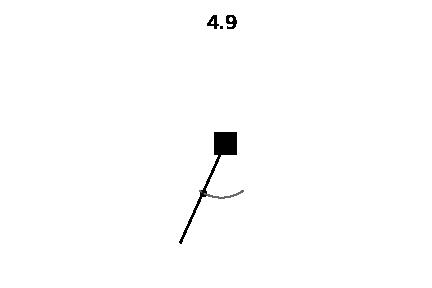

In [433]:
# We'll look at the pendulum down position
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 1, 'length_pole': 4, 'gravity': 10, 'friction': 0})
tmin, tmax = [0,50.5]
dt=.01
time = np.linspace(tmin,tmax,int((tmax-tmin)/dt))

A = c.A(-1)
B = c.B(1)
C = np.array([[1,0,0,0]])
D = np.zeros([C.shape[0], B.shape[1]])
ss = signal.StateSpace(A, B, C, D)

x0 = np.array([0, 0, 0.5, 0]) # relative to stationary point
xs = np.array([[0],[0],[np.pi],[0]])
tout, yout, xout = signal.lsim(ss, np.zeros_like(time[:500]), time[:500], x0)
x,px,th,pth = xout.T - xs

ch.make_movie_with_buffer(c, x, th, tout, tdiv=10)

In [434]:
# Augment the system with disturbances and noise
Wd = .1*np.identity(4)
Wn = np.array([[1]])

# Augmented control system inputs are (u, d, n)
augB = np.hstack([B, Wd, np.zeros([A.shape[0],Wn.shape[1]])])
augD = np.hstack([D, np.zeros([C.shape[0],Wd.shape[1]]), Wn])
augSS = signal.StateSpace(A,augB,C,augD)

# Kalman filter computes the dynamics of x_hat using measurements C and the model A, B
Kf = ch.lqr(A.T, C.T, Wd, Wn)[0].T
kfSS = signal.StateSpace(A-Kf@C, np.hstack([B, Kf]), np.identity(A.shape[0]), 0*np.hstack([B, Kf]))

# Simulate the system
d = np.random.multivariate_normal(np.zeros(A.shape[0]), Wd, len(time))
n = np.random.multivariate_normal(np.zeros(C.shape[0]), Wn, len(time))
u = np.zeros([len(time), B.shape[1]])
u[100:120] = 100 # 0.2 second pulse
u[1500:1520] = -100
augU = np.hstack([u, d, n])
tout, yout, xout = signal.lsim(augSS, augU, time)

# Use measurement and control signal to reconstruct the system
kf_u = np.hstack([u, yout.reshape(len(time),-1)])
kf_tout, kf_yout, kf_xout = signal.lsim(kfSS, kf_u, time)

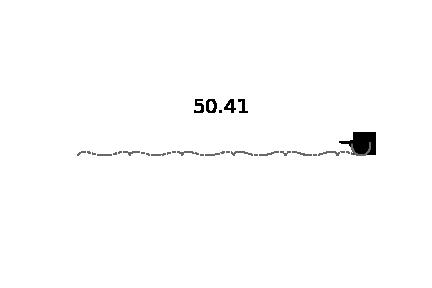

In [435]:
x,px,th,pth = xout.T - xs
ch.make_movie_with_buffer(c, x, th, tout, tdiv=20)

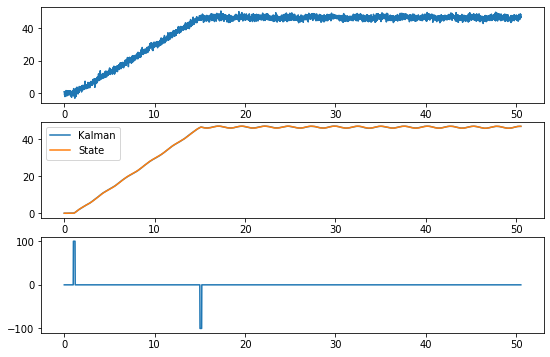

In [436]:
fig, axes = plt.subplots(3,1, figsize=[9,6])
axes[0].plot(time, yout, label='Measurement')
axes[1].plot(tout, kf_yout[:,0], label='Kalman')
axes[1].plot(tout, xout[:,0], label='State')
axes[1].legend()
axes[2].plot(tout, u)

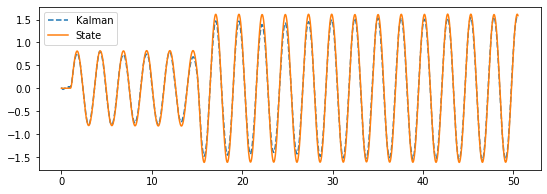

In [437]:
fig, ax = plt.subplots(1, figsize=[9,3])
ax.plot(tout, kf_yout[:,2], label='Kalman', ls='--')
ax.plot(tout, xout[:,2], label='State')
ax.legend()

# Observability and Controllability